In [57]:
import math
import os
from pathlib import Path

import numpy as np
import rasterio as rio
import rioxarray
from affine import Affine
from h3ronpy import raster
from h3ronpy.raster import nearest_h3_resolution, raster_to_dataframe
from rasterio.coords import BoundingBox
from rasterio.enums import Resampling
from rasterio.plot import show
from shapely.geometry import Polygon

In [2]:
raster?

Type:        module
String form: <module 'h3ronpy.raster' from '/home/biel/miniconda3/envs/geo/lib/python3.10/site-packages/h3ronpy/raster.py'>
File:        ~/miniconda3/envs/geo/lib/python3.10/site-packages/h3ronpy/raster.py
Docstring:  
Conversion of raster numpy arrays to h3.

Resolution search modes
-----------------------

* "min_diff": chose the h3 resolution where the difference in the area of a pixel and the h3index is as small as possible.
* "smaller_than_pixel":  chose the h3 resolution where the area of the h3index is smaller than the area of a pixel.


In [3]:
base_data_path = Path("../../h3_data_importer/data/")

## Resample woodpulp dataset to match the H3 resolution 6

In [119]:
wood_pulp_harvest = "../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha.tif"
with rio.open(wood_pulp_harvest) as src:
    print(src.crs)
    aff = src.transform
    bounds = src.bounds
    shape = src.shape

EPSG:4326


In [28]:
type(bounds)

rasterio.coords.BoundingBox

In [43]:
def find_h3_res_best_fit(transform: Affine, shape: tuple[int, int], bounds: BoundingBox, resolution: int) -> tuple:
    result = []

    for scale_factor in (x for x in range(1, 400)):
        x_pix_size = transform.a * scale_factor
        y_pix_size = transform.e * scale_factor

        shape = (int((bounds.right - bounds.left) / x_pix_size), int((bounds.bottom - bounds.top) / y_pix_size))
        new_trans = Affine(x_pix_size, transform.b, transform.c, transform.d, y_pix_size, transform.f)

        h3_res = nearest_h3_resolution(shape, new_trans, search_mode="min_diff")
        result.append((scale_factor, x_pix_size, shape, h3_res))

    return [x for x in res if x[-1] == resolution][:3]

In [44]:
find_h3_res_best_fit(aff, shape, bounds, 6)

[(181, 0.0452500000000003, (529, 762), 6),
 (183, 0.0457500000000003, (524, 754), 6),
 (185, 0.046250000000000305, (518, 746), 6)]

So ` 0.04525` deegres will be the smaller pixel size that can contain a res 6 H3 hexagon

which is `181` times bigger than the original res of `0.00025`

In [8]:
aff.a * 181

0.0452500000000003

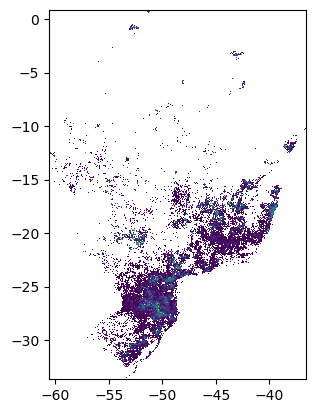

In [9]:
with rio.open("../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha_res.tif") as src:
    show(src, interpolation="none")
    df = raster_to_dataframe(
        src.read(1), src.transform, h3_resolution=6, nodata_value=src.nodata, compacted=False, geo=True
    )

<AxesSubplot:>

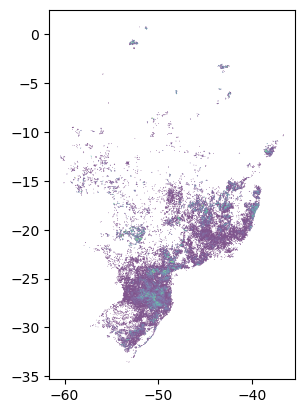

In [10]:
df.plot(column="value")

looks like successs!

In [11]:
df.to_file("../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha_h3.geojson", driver="GeoJSON")

## Sateligence ressampling to a bit smaller resolution

### Deforestation Mask

In [55]:
with rio.open("../../h3_data_importer/data/satelligence/Deforestation_Masked_2016-2022-10-01.tif") as src:
    target = find_h3_res_best_fit(src.transform, src.shape, src.bounds, 11)

In [56]:
target

[(3, 0.0007500000000000049, (31972, 46029), 11)]

So te target pix size to get a nice 11 res h3 will be `0.00075`

But first lets convert the mask to pixel area so we can sum easily during the resampling

In [85]:
deforest_mask = rioxarray.open_rasterio(
    "../../h3_data_importer/data/satelligence/Deforestation_Masked_2016-2022-10-01.tif"
)

In [138]:
# filter to get only the 2021 mask
deforest_mask.values = (deforest_mask.values == 2021).astype(int)

In [112]:
deforest_mask_3395 = deforest_mask.rio.reproject(dst_crs="epsg:3395").squeeze("band")
pix_size_3395 = deforest_mask_3395.rio.transform().a
pix_size_3395

29.164188908894495

In [113]:
pix_area_ha = pix_size_3395**2 / 10_000
print("Pixel size in Ha:", pix_area_ha)

Pixel size in Ha: 0.08505499147136847


In [137]:
deforest_ha_3395 = deforest_mask_3395.where(~deforest_mask_3395, pix_area_ha)

deforest_ha = deforest_ha_3395.rio.reproject(
    dst_crs="EPSG:4326", resolution=(0.00075, 0.00075), resampling=Resampling.sum
)

deforest_ha.rio.to_raster("../../h3_data_importer/data/satelligence/Deforestation_2021_ha.tif")

### Deforestation risk

In [139]:
deforest_risk = rioxarray.open_rasterio(
    "../../h3_data_importer/data/satelligence/DeforestationRisk_2016-2022-10-01.tif"
)

In [141]:
deforest_risk = deforest_risk.rio.reproject("EPSG:4326", resolution=(0.00075, 0.00075), resampling=Resampling.sum)
deforest_risk

<xarray.DataArray (band: 1, y: 1107, x: 1057)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -50.89 -50.89 -50.89 -50.88 ... -50.1 -50.1 -50.09
  * y            (y) float64 -23.74 -23.74 -23.74 ... -24.56 -24.56 -24.57
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999.0

In [142]:
deforest_risk.rio.to_raster('../../h3_data_importer/data/satelligence/Deforestation_risk.tif')